In [31]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import wfdb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras import layers, models
import tensorflow as tf

import os
import sklearn

2025-05-18 06:26:36.808017: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-18 06:26:36.899037: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-18 06:26:36.944293: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-18 06:26:36.957756: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-18 06:26:37.037305: I tensorflow/core/platform/cpu_feature_guar

In [3]:
if tf.config.list_physical_devices('GPU'):
  print("TensorFlow **IS** using the GPU")
else:
  print("TensorFlow **IS NOT** using the GPU")

TensorFlow **IS** using the GPU


I0000 00:00:1747542403.094310    3264 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1747542403.277453    3264 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1747542403.278142    3264 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


# Helper functions

### Metrics

In [4]:
import tensorflow.keras.backend as K

def sensitivity(y_true, y_pred):
  y_pred_classes = K.argmax(y_pred, axis=-1)
  true_positives = K.sum(K.cast(y_pred_classes[y_true == 1] == 1, 'float32'))
  possible_positives = K.sum(K.cast(y_true == 1, 'float32'))
  return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
  y_pred_classes = K.argmax(y_pred, axis=-1)
  true_negatives = K.sum(K.cast(y_pred_classes[y_true == 0] == 0, 'float32'))
  possible_negatives = K.sum(K.cast(y_true == 0, 'float32'))
  return true_negatives / (possible_negatives + K.epsilon())

from tensorflow.keras.metrics import F1Score

f1_metric = F1Score()

from tensorflow.keras.metrics import SparseCategoricalAccuracy

accuracy = SparseCategoricalAccuracy(name='accuracy')

I0000 00:00:1747542403.321896    3264 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1747542403.322492    3264 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1747542403.322774    3264 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1747542403.433761    3264 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

### Data loading

In [5]:
def load_signals():

    path = "../data/training2017/"

    records = os.listdir(path)

    records = [record for record in records if record.endswith('.mat')]

    records = [os.path.splitext(record)[0] for record in records]

    records.sort()

    signals = [wfdb.rdrecord(record_name=path+record).p_signal for record in records]

    fs = wfdb.rdrecord(record_name=path+records[0]).fs

    signals_flat = []
    for signal in signals:
        signal_flat = [sample[0] for sample in signal]
        signal_flat = np.array(signal_flat)
        signals_flat.append(signal_flat)

    signals_flat = np.asarray(signals_flat, dtype=np.ndarray)
    
    return signals_flat

signals_flat = load_signals()

### EDA

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram

def plot_psd_heatmap(signals, fs=300):
    """
    Plots a power spectral density (PSD) heatmap using periodogram.
    
    Parameters:
        signals (array-like): List or array of 1D signals (same length).
        fs (float): Sampling frequency in Hz.
    """
    signals = np.array(signals.tolist(), dtype=np.float32)  # convert object array to float
    num_signals = len(signals)
    
    # Compute PSD for each signal
    freqs, psd = periodogram(signals, fs=fs, axis=1)

    # Convert to dB scale (optional but common)
    psd_db = 10 * np.log10(psd + 1e-12)  # avoid log(0)
    #psd_db = psd
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.imshow(psd_db, aspect='auto', origin='lower',
               extent=[freqs[0], freqs[-1], 0, num_signals],
               cmap='viridis')
    plt.colorbar(label='Power Spectral Density (dB/Hz)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Signal Index')
    plt.title('PSD Heatmap using Periodogram')
    plt.tight_layout()
    plt.show()

### Modifying signal length

In [7]:
def cut_signals_shortest(signals_flat):
     # Get the minimum length across all signals
    lengths = [len(signal) for signal in signals_flat]
    min_length = min(lengths)
    
    # Create the middle slices for each signal
    signals_middle = []
    for signal in signals_flat:
        signal_length = len(signal)
        
        # Calculate the start and end indices for the middle of each signal
        start = (signal_length // 2 - min_length // 2)
        end = start + min_length
        
        # Slice the signal to keep the middle part
        signals_middle.append(signal[start:end])
    
    # Convert the list of signals to a NumPy array
    signals_middle = np.array(signals_middle)
    
    return signals_middle

In [8]:
def extract_center_5s(signals, target_length=600):
    """
    Extract central 5 seconds (600 samples at 120Hz) from each signal.
    If signal is shorter than 600, pad with zeros (centered).
    
    Parameters:
        signals: array-like of 1D numpy arrays (downsampled ECG signals)
        target_length: number of samples to extract (default is 600 for 5s at 120Hz)
        
    Returns:
        np.ndarray of shape (num_signals, target_length)
    """
    processed = []

    for signal in signals:
        sig_len = len(signal)

        if sig_len >= target_length:
            start = (sig_len - target_length) // 2
            segment = signal[start:start + target_length]
        else:
            pad_len = target_length - sig_len
            pad_left = pad_len // 2
            pad_right = pad_len - pad_left
            segment = np.pad(signal, (pad_left, pad_right), mode='constant')

        processed.append(segment)

    return np.array(processed, dtype=np.float32)

In [43]:
def sliding_window_5s(signals, window_size=600, stride=1):
    """
    Extract overlapping 5-second windows using sliding window technique.
    
    Parameters:
        signals: array-like of 1D numpy arrays (downsampled ECG signals)
        window_size: number of samples in one window (default is 600)
        stride: number of samples to slide the window (default is 1)
    
    Returns:
        list of np.ndarray, each array of shape (num_windows, window_size)
    """
    all_windows = []

    for signal in signals:
        sig_len = len(signal)
        if sig_len < window_size:
            # Pad with zeros to allow a single window
            pad_len = window_size - sig_len
            pad_left = pad_len // 2
            pad_right = pad_len - pad_left
            signal = np.pad(signal, (pad_left, pad_right), mode='constant')
            sig_len = len(signal)

        num_windows = 1 + (sig_len - window_size) // stride
        windows = np.stack([
            signal[i:i+window_size]
            for i in range(0, sig_len - window_size + 1, stride)
        ])
        all_windows.append(windows.astype(np.float32))

    return all_windows

In [9]:
# Per-signal z-score normalization (recommended for ECG)
# signals_short = (signals_short - signals_short.mean(axis=1, keepdims=True)) / (signals_short.std(axis=1, keepdims=True) + 1e-8)

### Loading labels

In [10]:
def load_labels():

    data = pd.read_csv(filepath_or_buffer="../data/training2017/REFERENCE-v3.csv", names=["signal_name", "label"])

    data["label"] = data["label"].astype("category").cat.codes

    data = data.drop(["signal_name"], axis=1)

    y = np.array(data["label"])
    
    return y

### Removing extra classes

In [11]:
def remove_extra_classes(X, y):

    classes_to_remove = [2, 3]

    classes, counts = np.unique(y, return_counts=True)

    # Display results
    print("Before removing \n")
    for c, count in zip(classes, counts):
        print(f"Class {c}: {count} samples")


    mask = ~np.isin(y, classes_to_remove)

    X = X[mask]
    y = y[mask]

    classes, counts = np.unique(y, return_counts=True)

    print("\nAfter removing \n")
    for c, count in zip(classes, counts):
        print(f"Class {c}: {count} samples")
        
    return X, y

### Normalisation (-1,1)

In [12]:
def normalize_to_minus1_1(signals):
    norm_signals = []
    for x in signals:
        x_min = np.min(x)
        x_max = np.max(x)
        if x_max != x_min:
            x_norm = 2 * (x - x_min) / (x_max - x_min) - 1
        else:
            x_norm = np.zeros_like(x)  # Avoid division by zero
        norm_signals.append(x_norm)
    return np.array(norm_signals, dtype=object)


### Oversampling

In [13]:
from imblearn.over_sampling import RandomOverSampler

In [14]:
from sklearn.utils.class_weight import compute_class_weight

def get_class_weights(y):
    # Convert one-hot labels to integers
    y_train_labels = np.argmax(y_train, axis=1)

    # Compute class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
    class_weight_dict = dict(enumerate(class_weights))
    
    return class_weight_dict

### Models, hyperparameter optimization and validation

In [15]:
from tensorflow.keras.utils import to_categorical

In [16]:
def make_model_conv1D(input_shape):
    input_layer = layers.Input(shape=(input_shape, 1))

    # Block 1
    x = layers.Conv1D(32, kernel_size=7, padding="same")(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    # Block 2
    x = layers.Conv1D(64, kernel_size=5, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    # Block 3
    x = layers.Conv1D(128, kernel_size=3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.GlobalAveragePooling1D()(x)

    # Optional: Dropout for regularization
    x = layers.Dropout(0.5)(x)

    output_layer = layers.Dense(4, activation="softmax")(x)

    return models.Model(inputs=input_layer, outputs=output_layer)

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, ReLU, Input, Softmax

def build_custom_vgg_1d(input_length=3000, num_classes=4):
    model = Sequential()
    model.add(Input(shape=(input_length, 1)))  # 1D signal input

    # Layer 1
    model.add(Conv1D(64, kernel_size=3, padding='same'))
    model.add(ReLU())
    model.add(Conv1D(64, kernel_size=3, padding='same'))
    model.add(ReLU())
    model.add(MaxPooling1D(pool_size=3, strides=3))

    # Layer 2
    model.add(Conv1D(128, kernel_size=3, padding='same'))
    model.add(ReLU())
    model.add(Conv1D(128, kernel_size=3, padding='same'))
    model.add(ReLU())
    model.add(MaxPooling1D(pool_size=3, strides=3))

    # Layer 3
    model.add(Conv1D(256, kernel_size=3, padding='same'))
    model.add(ReLU())
    model.add(Conv1D(256, kernel_size=3, padding='same'))
    model.add(ReLU())
    model.add(Conv1D(256, kernel_size=3, padding='same'))
    model.add(ReLU())
    model.add(MaxPooling1D(pool_size=2, strides=2))

    # Layer 4
    model.add(Conv1D(512, kernel_size=3, padding='same'))
    model.add(ReLU())
    model.add(Conv1D(512, kernel_size=3, padding='same'))
    model.add(ReLU())
    model.add(Conv1D(512, kernel_size=3, padding='same'))
    model.add(ReLU())
    model.add(MaxPooling1D(pool_size=2, strides=2))

    # Layer 5
    model.add(Conv1D(512, kernel_size=3, padding='same'))
    model.add(ReLU())
    model.add(Conv1D(512, kernel_size=3, padding='same'))
    model.add(ReLU())
    model.add(Conv1D(512, kernel_size=3, padding='same'))
    model.add(ReLU())
    model.add(MaxPooling1D(pool_size=2, strides=2))

    model.add(Flatten())

    # Layer 6, 7, 8: Fully connected layers
    model.add(Dense(1024, activation='relu'))  # Layer 6
    model.add(Dense(1024, activation='relu'))  # Layer 7
    model.add(Dense(256, activation='relu'))   # Layer 8

    # Layer 9: Output softmax
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [18]:
from tensorflow.keras.layers import Concatenate, BatchNormalization
from tensorflow.keras.models import Model

def conv_block(x, filters, kernel_size, blocks, pool_stride):
    for _ in range(blocks):
        x = Conv1D(filters, kernel_size, padding='same')(x)
        x = BatchNormalization()(x)
        # x = ReLU()(x)
    x = MaxPooling1D(pool_size=2, strides=pool_stride, padding='same')(x)
    return x

def build_dual_stream_model(input_length=3000, num_classes=2):
    input_layer = Input(shape=(input_length, 1))

    # Stream 1 (kernel size = 3)
    s1 = conv_block(input_layer, 64, 3, 2, 3)    # Layer 1
    s1 = conv_block(s1, 128, 3, 2, 3)            # Layer 2
    s1 = conv_block(s1, 256, 3, 3, 2)            # Layer 3
    s1 = conv_block(s1, 512, 3, 3, 2)            # Layer 4
    s1 = conv_block(s1, 512, 3, 3, 2)            # Layer 5
    s1 = Flatten()(s1)

    # Stream 2 (kernel size = 5 for first two layers, then same as stream 1)
    s2 = conv_block(input_layer, 64, 5, 2, 3)    # Layer 1
    s2 = conv_block(s2, 128, 5, 2, 3)            # Layer 2
    s2 = conv_block(s2, 256, 3, 3, 2)            # Layer 3
    s2 = conv_block(s2, 512, 3, 3, 2)            # Layer 4
    s2 = conv_block(s2, 512, 3, 3, 2)            # Layer 5
    s2 = Flatten()(s2)

    # Merge
    merged = Concatenate()([s1, s2])

    # Fully connected layers
    x = Dense(1024, activation='relu')(merged)
    x = Dense(1024, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output)
    return model

In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv1D

class MaskedConv1D(Layer):
    def __init__(self, filters, kernel_size, **kwargs):
        super(MaskedConv1D, self).__init__()
        self.conv = Conv1D(filters, kernel_size, padding='same', **kwargs)

    def call(self, inputs, mask=None):
        x = self.conv(inputs)
        if mask is not None:
            mask = tf.cast(tf.expand_dims(mask, axis=-1), x.dtype)
            x *= mask
        return x

    def compute_mask(self, inputs, mask=None):
        return mask


In [38]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Masking, ReLU, MaxPooling1D, GlobalAveragePooling1D,
    Dense, Concatenate, BatchNormalization
)

def masked_conv_block(x, filters, kernel_size, blocks, pool_stride):
    for _ in range(blocks):
        x = MaskedConv1D(filters, kernel_size)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
    x = MaxPooling1D(pool_size=2, strides=pool_stride, padding='same')(x)
    return x

def build_model(input_length=600, trial=None, tune=False,
                dense_units=512, learning_rate=1e-3, batch_size=32):
    input_layer = Input(shape=(input_length, 1))
    masked_input = Masking(mask_value=0.0)(input_layer)

    # If tuning, get hyperparameters from trial
    if tune and trial is not None:
        dense_units = trial.suggest_int("dense_units", 128, 1024, step=128)
        learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
        batch_size = trial.suggest_categorical("batch_size", [32, 64])

    # Stream 1
    s1 = masked_conv_block(masked_input, 64, 3, 2, 3)
    s1 = masked_conv_block(s1, 128, 3, 2, 3)
    s1 = masked_conv_block(s1, 256, 3, 3, 2)
    s1 = masked_conv_block(s1, 512, 3, 3, 2)
    s1 = GlobalAveragePooling1D()(s1)

    # Stream 2
    s2 = masked_conv_block(masked_input, 64, 5, 2, 3)
    s2 = masked_conv_block(s2, 128, 5, 2, 3)
    s2 = masked_conv_block(s2, 256, 3, 3, 2)
    s2 = masked_conv_block(s2, 512, 3, 3, 2)
    s2 = GlobalAveragePooling1D()(s2)

    merged = Concatenate()([s1, s2])
    x = Dense(dense_units, activation='relu')(merged)
    x = Dense(dense_units, activation='relu')(x)
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model, batch_size  # Also return batch_size for training


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def objective(trial):
    # Load and preprocess data
    X = X_data  # shape (N, 600, 1)
    y = y_data  # shape (N,) with 0 or 1

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)
    
    X_train, y_train = RandomOverSampler().fit_resample(X_train, y_train)

    y_train = to_categorical(y_train, num_classes=2)
    y_val = to_categorical(y_val, num_classes=2)

    model, batch_size = build_model(input_length=600, trial=trial, tune=True)
    
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=10,
                        batch_size=trial.suggest_categorical("batch_size", [32, 64]),
                        verbose=0)
    
    # Evaluate
    val_preds = (model.predict(X_val) > 0.5).astype(int)
    val_acc = accuracy_score(y_val, val_preds)
    return 1.0 - val_acc  # Optuna minimizes

### Evaluation

In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

def evaluate_model(model, X_test, y_test, one_hot_labels=True):
    """
    Evaluates a Keras model on a test set and prints:
    - Confusion matrix
    - Per-class sensitivity and specificity
    - Overall accuracy

    Parameters:
    - model: Trained Keras model
    - X_test: Test input data (NumPy array)
    - y_test: True labels (one-hot encoded or integer)
    - one_hot_labels: Set to True if y_test is one-hot encoded
    """
    
    # Convert predictions and labels to class indices
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    if one_hot_labels:
        y_true = np.argmax(y_test, axis=1)
    else:
        y_true = y_test

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Overall Accuracy: {accuracy:.4f}")

    # Sensitivity & Specificity
    num_classes = cm.shape[0]
    sensitivity = []
    specificity = []

    for i in range(num_classes):
        TP = cm[i, i]
        FN = np.sum(cm[i, :]) - TP
        FP = np.sum(cm[:, i]) - TP
        TN = np.sum(cm) - (TP + FN + FP)

        sens = TP / (TP + FN) if (TP + FN) != 0 else 0
        spec = TN / (TN + FP) if (TN + FP) != 0 else 0

        sensitivity.append(sens)
        specificity.append(spec)

        print(f"Class {i}: Sensitivity = {sens:.4f}, Specificity = {spec:.4f}")

In [23]:
from sklearn.model_selection import KFold

def run_kfold_cross_validation(X, y, build_model_fn, num_folds=10, epochs=10, batch_size=32):
    """
    Run k-fold cross-validation for a Keras model.

    Parameters:
        X (np.ndarray): Input features of shape (samples, length).
        y (np.ndarray): Labels of shape (samples,) or one-hot encoded.
        build_model_fn (function): A function that returns a compiled Keras model.
        num_folds (int): Number of folds for cross-validation.
        epochs (int): Training epochs per fold.
        batch_size (int): Training batch size.
        one_hot (bool): If True, converts labels to one-hot encoding.

    Returns:
        List of validation accuracies per fold.
    """
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    val_accuracies = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
        print(f"\n📘 Fold {fold}/{num_folds}")

        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model = build_model_fn()

        model.fit(X_train, y_train,
                  validation_data=(X_val, y_val),
                  epochs=epochs,
                  batch_size=batch_size,
                  verbose=0)

        val_acc = model.evaluate(X_val, y_val, verbose=0)[1]
        val_accuracies.append(val_acc)
        print(f"✅ Fold {fold} Accuracy: {val_acc:.4f}")

    avg_accuracy = np.mean(val_accuracies)
    print(f"\n🎯 Average Validation Accuracy: {avg_accuracy:.4f}")
    return val_accuracies

## Preprocessing

In [24]:
from scipy.signal import butter, filtfilt

def low_pass_filter(X, fs_original=300, cutoff_freq=60):
    # Design the low-pass filter (Butterworth filter)
    nyquist = 0.5 * fs_original  # Nyquist frequency
    normal_cutoff = cutoff_freq / nyquist  # Normalize the cutoff frequency
    
    # Create the low-pass filter
    b, a = butter(4, normal_cutoff, btype='low', analog=False)
    
    # Apply the low-pass filter to each signal (row) in X
    filtered_X = []
    for signal in X:
        # Apply the filter to each signal
        filtered_signal = filtfilt(b, a, signal)
        
        # Trim any extra edge artifacts (in case of filter edge effects)
        filtered_signal = filtered_signal[:len(signal)]
        
        filtered_X.append(filtered_signal)
    
    # Return as a list of arrays (each signal with its own length)
    return filtered_X

In [25]:
def downsample_signal(X, fs_original=300, fs_new=120):
    downsampled_X = []
    
    # Down-sample each signal (row) in X individually
    for signal in X:
        # Calculate the down-sample factor
        downsample_factor = fs_original // fs_new
        
        # Down-sample the signal based on the calculated factor
        downsampled_signal = signal[::downsample_factor]
        downsampled_X.append(downsampled_signal)
    
    # Return as a list of downsampled signals (each signal with its own length)
    return downsampled_X

In [26]:
def plot_fft(signal, fs=300):
    """
    Calculate and plot the FFT of a signal.
    
    Parameters:
    - signal: The input signal (1D array)
    - fs: The sampling frequency (default 300 Hz)
    """
    # Number of samples in the signal
    n = len(signal)
    
    # Compute the FFT
    fft_signal = np.fft.fft(signal)
    
    # Compute the frequencies corresponding to the FFT bins
    freqs = np.fft.fftfreq(n, 1/fs)
    
    # Take the absolute value of the FFT (magnitude)
    fft_magnitude = np.abs(fft_signal)
    
    # Only keep the positive half of the spectrum (real frequencies)
    positive_freqs = freqs[:n//2]
    positive_fft_magnitude = fft_magnitude[:n//2]
    
    # Plot the FFT magnitude vs frequency
    plt.figure(figsize=(10, 6))
    plt.plot(positive_freqs, positive_fft_magnitude)
    plt.title('FFT of Signal')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.show()

# Execution

### Preprocessing

In [39]:
X = signals_flat
y = load_labels()

X, y = remove_extra_classes(X, y)

Before removing 

Class 0: 758 samples
Class 1: 5076 samples
Class 2: 2415 samples
Class 3: 279 samples

After removing 

Class 0: 758 samples
Class 1: 5076 samples


### 2 stream 5s

In [40]:
X, y = remove_extra_classes(X, y)

X_filtered = low_pass_filter(X=X)

X_downsampled = downsample_signal(X=X_filtered)

X_normalised = normalize_to_minus1_1(X_downsampled)

signal_seconds = 5
sampling_freq = 120
signal_len = signal_seconds * sampling_freq
X = extract_center_5s(signals=X_normalised, target_length=signal_len)
X = sliding_window_5s(signals, window_size=600, stride=1)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, test_size=0.2, random_state=42)

X_train, y_train = RandomOverSampler().fit_resample(X_train, y_train)

y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

X_train = np.array(X_train.tolist(), dtype=np.float32)  
X_train = np.expand_dims(X_train, axis=-1)

X_test = np.array(X_test.tolist(), dtype=np.float32)  
X_test = np.expand_dims(X_test, axis=-1)

Before removing 

Class 0: 758 samples
Class 1: 5076 samples

After removing 

Class 0: 758 samples
Class 1: 5076 samples


Epoch 1/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 74s 180ms/step - accuracy: 0.6109 - loss: 0.7435 - val_accuracy: 0.0000e+00 - val_loss: 1.3849
Epoch 2/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 16s 77ms/step - accuracy: 0.7136 - loss: 0.5859 - val_accuracy: 0.5920 - val_loss: 0.7883
Epoch 3/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 16s 77ms/step - accuracy: 0.7926 - loss: 0.4547 - val_accuracy: 0.9988 - val_loss: 0.0187
Epoch 4/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 16s 77ms/step - accuracy: 0.8600 - loss: 0.3114 - val_accuracy: 0.9141 - val_loss: 0.2198
Epoch 5/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 16s 78ms/step - accuracy: 0.8870 - loss: 0.2630 - val_accuracy: 0.7509 - val_loss: 0.6354
Epoch 6/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 16s 78ms/step - accuracy: 0.9004 - loss: 0.2347 - val_accuracy: 0.9061 - val_loss: 0.2409
Epoch 7/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 16s 77ms/step - accuracy: 0.9224 - loss: 0.2000 - val_accuracy: 0.8755 - val_loss: 0.3296
Epoch 8/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 16s 77ms/step - accuracy: 0.9313 - loss: 0.17

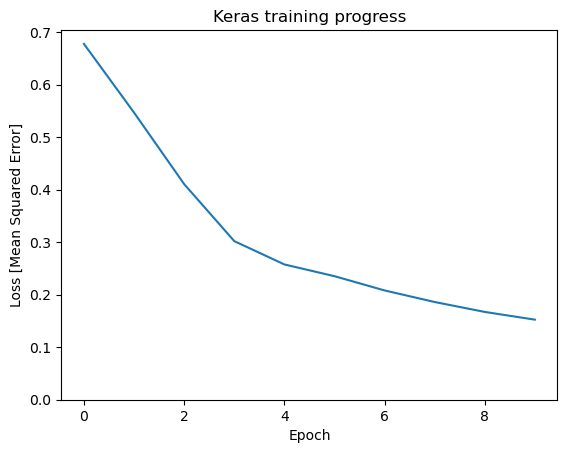

In [41]:
input_size = len(X_train[0])
epochs = 10
batch_size = 32

# model = make_model_conv1D(input_shape=input_size)
# model = build_custom_vgg_1d(input_length=input_size, num_classes=2)
# model = build_dual_stream_model(input_length=input_size, num_classes=2)
model, batch_size = build_model(input_length=input_size, trial=None, tune=False,
                dense_units=640, learning_rate=0.0021803189997713648, batch_size=32)

# # model.compile(
#     optimizer='adam',
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    verbose=1,
)

plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss [Mean Squared Error]')
plt.title('Keras training progress');

In [ ]:
val_accs = run_kfold_cross_validation(X=X, y=y, build_model_fn=build_custom_vgg_1d, num_folds=10, epochs=10, batch_size=32)

In [42]:
evaluate_model(model=model, X_test=X_test, y_test=y_test)

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step
Confusion Matrix:
 [[140  25]
 [ 83 919]]
Overall Accuracy: 0.9075
Class 0: Sensitivity = 0.8485, Specificity = 0.9172
Class 1: Sensitivity = 0.9172, Specificity = 0.8485


### hyperparameter optimization

In [32]:
import optuna

X_data = X
y_data = y

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

print("Best trial:")
print("  Accuracy: {:.2f}%".format((1.0 - study.best_value) * 100))
print("  Params: ", study.best_params)

[I 2025-05-15 10:34:13,844] A new study created in memory with name: no-name-3c2f4fc7-f3c8-4c50-895e-86c46b6ecfa4
/home/nihad/anaconda3/envs/zavrsni_master/lib/python3.12/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'max_pooling1d_8' (of type MaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/nihad/anaconda3/envs/zavrsni_master/lib/python3.12/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'max_pooling1d_12' (of type MaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/nihad/anaconda3/envs/zavrsni_master/lib/python3.12/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'conv1d_30' (of type Conv1D) was passed 

[W 2025-05-15 10:34:30,788] Trial 0 failed with value None.


KeyboardInterrupt: 

### PCA

array([1, 1, 1, ..., 1, 1, 1], dtype=int8)

/home/nihad/anaconda3/envs/zavrsni_master/lib/python3.12/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'conv1d_591' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/nihad/anaconda3/envs/zavrsni_master/lib/python3.12/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'conv1d_581' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/nihad/anaconda3/envs/zavrsni_master/lib/python3.12/site-packages/keras/src/layers/layer.py:940: UserWarning: Layer 'conv1d_592' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downs

Explained variance by each of 5 principal components:
PC1: 0.8849
PC2: 0.1120
PC3: 0.0012
PC4: 0.0007
PC5: 0.0004

Total information coverage (5 PCs): 0.9992


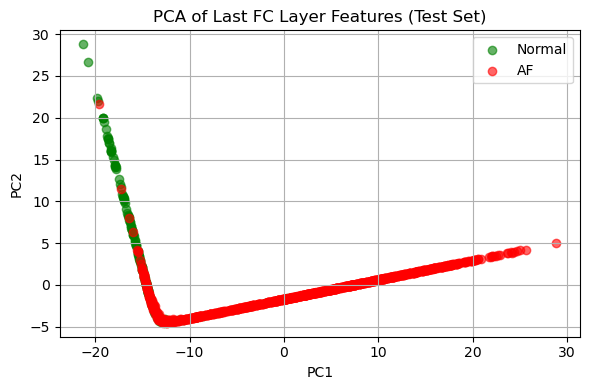

In [150]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

# Step 1: Extract output of last FC layer (before sigmoid)
feature_layer = model.layers[-2].output
feature_extractor = Model(inputs=model.input, outputs=feature_layer)

# Step 2: Get features for entire test set
features = feature_extractor.predict(X_test, verbose=0)  # Shape (N, D)

# Step 3: Apply PCA to reduce to 5 components
pca = PCA(n_components=5)
reduced_features = pca.fit_transform(features)

# Step 4: Print explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.sum(explained_variance)

print("Explained variance by each of 5 principal components:")
for i, ratio in enumerate(explained_variance, start=1):
    print(f"PC{i}: {ratio:.4f}")

print(f"\nTotal information coverage (5 PCs): {cumulative_variance:.4f}")

# Step 5: Optional 2D scatter plot for PC1 vs PC2
plt.figure(figsize=(6, 4))
plt.scatter(reduced_features[y_test == 0, 0], reduced_features[y_test == 0, 1],
            label="Normal", alpha=0.6, color="green")
plt.scatter(reduced_features[y_test == 1, 0], reduced_features[y_test == 1, 1],
            label="AF", alpha=0.6, color="red")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Last FC Layer Features (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [1]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

def extract_features_by_layer_indices(model, X, y, layer_indices):
    """
    Extracts features from specific Conv/FC layer indices (based on Conv/FC count, not layer index).
    Returns a dict {layer_name: reduced_features}
    """
    features_dict = {}
    conv_fc_count = 0
    selected_outputs = []
    selected_names = []

    for layer in model.layers:
        if isinstance(layer, (tf.keras.layers.Conv1D, tf.keras.layers.Dense, MaskedConv1D)):
            conv_fc_count += 1
            if conv_fc_count in layer_indices:
                selected_outputs.append(layer.output)
                selected_names.append(f"Layer{conv_fc_count}_{layer.name}")

    feature_model = Model(inputs=model.input, outputs=selected_outputs)
    features_list = feature_model.predict(X, verbose=0)

    for name, feats in zip(selected_names, features_list):
        if len(feats.shape) == 3:
            feats = tf.reduce_mean(feats, axis=1).numpy()
        elif len(feats.shape) == 1:
            feats = feats.reshape(-1, 1)

        if feats.shape[1] >= 5:
            pca = PCA(n_components=5)
            reduced = pca.fit_transform(feats)
            coverage = np.sum(pca.explained_variance_ratio_)
            features_dict[name] = (reduced, coverage)
            print(f"{name}: {coverage:.4f} variance explained by 5 PCs")
        else:
            print(f"{name}: Skipped PCA — not enough features (got {feats.shape[1]})")

    return features_dict


2025-05-09 17:04:48.237581: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-09 17:04:48.303174: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-09 17:04:48.320319: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-09 17:04:48.324687: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-09 17:04:48.382685: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
# Use test data
layer_indices = [2, 4, 7, 10, 13, 16]
features_by_layer = extract_features_by_layer_indices(model, X_test, y_test, layer_indices)

# Optional: plot PCA of one layer
# reduced_feats, _ = features_by_layer['Layer16_dense_2']  # Example
# plt.scatter(reduced_feats[y_test == 0, 0], reduced_feats[y_test == 0, 1], label='Normal', alpha=0.6)
# plt.scatter(reduced_feats[y_test == 1, 0], reduced_feats[y_test == 1, 1], label='AF', alpha=0.6)
# plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend(); plt.title("Layer 16 PCA"); plt.grid(True); plt.tight_layout(); plt.show()


In [156]:
X_test

array([[-0.6314382 , -0.6357738 , -0.63880193, ..., -0.67383444,
        -0.6703082 , -0.6679079 ],
       [-0.4654801 , -0.4807946 , -0.49080408, ..., -0.31707922,
        -0.31356508, -0.31359303],
       [-0.7084222 , -0.7368452 , -0.7368704 , ..., -0.66566336,
        -0.6618546 , -0.6632435 ],
       ...,
       [-0.18685642, -0.20766897, -0.21703391, ...,  0.13423714,
         0.14159389,  0.15712494],
       [-0.17392287, -0.17463478, -0.21200258, ..., -0.46309105,
        -0.45886764, -0.4543725 ],
       [-0.21736747, -0.21707392, -0.21679112, ..., -0.19282693,
        -0.19435845, -0.19739065]], dtype=float32)

## LSTM

### with masking

In [120]:
input_shape = (max_length, 1)

In [121]:
def create_model_with_masking(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # Masking layer to handle padded values (assuming padding value is 0)
    masked_inputs = layers.Masking(mask_value=0.0)(inputs)
    
    # LSTM layer
    lstm_out = layers.LSTM(64, return_sequences=False)(masked_inputs)
    
    # Dense output layer
    outputs = layers.Dense(4, activation='softmax')(lstm_out)
    
    model = models.Model(inputs, outputs)
    return model

In [122]:
model_with_masking = create_model_with_masking(input_shape)


model_with_masking.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Train the model
model_with_masking.fit(X_train, y_train, epochs=10, batch_size=32) 

Epoch 1/10


2025-05-04 18:17:06.803660: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


 15/179 ━━━━━━━━━━━━━━━━━━━━ 25:59 10s/step - accuracy: 0.3955 - loss: 1.3753

KeyboardInterrupt: 

### without masking

In [123]:
def create_model_without_masking(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # LSTM layer
    lstm_out = layers.LSTM(64, return_sequences=False)(inputs)
    
    # Dense output layer
    outputs = layers.Dense(4, activation='softmax')(lstm_out)
    
    model = models.Model(inputs, outputs)
    return model

In [124]:
model_without_masking = create_model_without_masking(input_shape)


model_without_masking.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Train the model
model_without_masking.fit(X_train, y_train, epochs=10, batch_size=32) 

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1386s 8s/step - accuracy: 0.5612 - loss: 1.1012
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 42623s 239s/step - accuracy: 0.5951 - loss: 0.9894
Epoch 3/10
175/179 ━━━━━━━━━━━━━━━━━━━━ 31s 8s/step - accuracy: 0.5929 - loss: 0.9877

KeyboardInterrupt: 

In [72]:
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

# Assuming 'create_model_with_masking' is defined as in the previous message

# Generate synthetic training data
num_samples = 1000
max_sequence_length = 50
num_features = 1  # Single feature per timestep
num_classes = 4  # Number of output classes

# Random sequences with varying lengths
X_train = [np.random.rand(np.random.randint(1, max_sequence_length + 1), num_features) for _ in range(num_samples)]
y_train = np.random.randint(0, num_classes, size=num_samples)

# Pad sequences to ensure uniform input size
X_train_padded = np.array([np.pad(seq, ((0, max_sequence_length - len(seq)), (0, 0)), mode='constant') if len(seq) < max_sequence_length else seq[:max_sequence_length] for seq in X_train])

# Define the model
input_shape = (max_sequence_length, num_features)
model_with_masking = create_model_with_masking(input_shape)

# Compile the model
model_with_masking.compile(
    optimizer=Adam(),
    loss=SparseCategoricalCrossentropy(),
    metrics=[SparseCategoricalAccuracy()]
)

# Train the model
model_with_masking.fit(X_train_padded, y_train, epochs=10, batch_size=32)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.3877 - sparse_categorical_accuracy: 0.2661
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3864 - sparse_categorical_accuracy: 0.2737
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3860 - sparse_categorical_accuracy: 0.2548
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3854 - sparse_categorical_accuracy: 0.2684
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3848 - sparse_categorical_accuracy: 0.2725
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3859 - sparse_categorical_accuracy: 0.2677
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3842 - sparse_categorical_accuracy: 0.2750
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3846 - sparse_categorical_accuracy: 0.2719
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3852 - sparse_categorical_accuracy: 0.2757
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.38